# MLE Optimization for Regression Models

## Introduction

The goal of regression is to predict the value of one or more continuous target variables t given the value of a D-dimensional vector x of input variables. The polynomial is a specific example of a broad class of functions called linear regression models. The simplest form of linear regression models are also linear functions of the input variables. However, much more useful class of functions can be constructed by taking linear combinations of a fix set of nonlinear functions of the input variables, known as _basis functions_ [1](https://en.wikipedia.org/wiki/Basis_function).

| |
|-|
| <img src="https://raw.githubusercontent.com/setrar/SSP/main/Homework/1/support/images/MLE-SGD_bf-reg.png" width='' height='' /> |

Regression models can be used for time series modeling. Typically, a regression model provides a projection from the baseline status to some relevant demographic variables. Curve-type time series data are quite common examples of these kinds of variables. Typical time series model is the ARMA model. It’s a combination of two types of time series data processes, namely, autoregressive and moving average processes.

Both, regression and time series models uses maximum likelihood estimation optimization for finding optimal parameters of the model. This likelihood principle says that, given that the assumed model is correct, all that the data have to tell us about the parameters is contained in the likelihood function, all other aspects of the data being irrelevant. From a Bayesian point of view, the likelihood function is equally important, since it is the component in the posterior distribution of the parameters that comes from the data

## Basis Function Models

Often times we want to model data that emerges from some underlying function f(x) of independent variables such that for some future input x we’ll be able to accurately predict the future output values. There are various methods for devising such a model, all of which make particular assumptions about the types of functions the model can emulate. In this post we’ll focus on one set of methods called Basis Function Models (BFMs).

There is a class of models represented by linear combinations of fixed nonlinear functions of the input variables, of the form

 $$y(x,w)=\sum_{j=0}^{M-1}w_i\phi_i(x) = w^T \phi(x)$$

$$ \text{ where  } w=(w_0, w_1, ..., w_M-1)^T \text{ and } \phi=(\phi_0, \phi_1, ..., \phi_M-1)^T $$

- It is often convenient to define an additional dummy basis function : $$ \phi_0(x) = 1$$
- Basis functions are also sometimes called `kernels`.


In [5]:
using Distributions

Naturally, we would define this function in Julia as

In [6]:
y(x::Real, w; ϕ=ϕ) = w'ϕ(x)

y (generic function with 2 methods)

but we also might need more efficient broadcast version for 
N-dimensional input is

In [7]:
y(xs, w; ϕ=ϕ) = [w'].*(ϕ.(xs)) # broadcasted w'ϕ(x)

y (generic function with 2 methods)

We initialize some auxiliary packages for plotting and random number generation

In [8]:
using Plots  # plotting
using Flux   # ML / AD
using Random # RNG
default(fmt = :png)

and generate some random weights for our example models.

In [9]:
Random.seed!(1)
d, n = 3, 5
xs = -5.0:0.1:5 
@show xs
ws = randn(d,n)

xs = -5.0:0.1:5.0


3×5 Matrix{Float64}:
  0.0619327   0.0466594  0.17594    1.54641   -0.39152
  0.278406    1.08579    0.865381  -0.584198   0.584412
 -0.595824   -1.57656    0.972024   0.467749  -0.0313159

Let’s take a look at examples of basis function models for creating a some data trends.

$$\text{ We start with polynomial basis: } \phi_j(x) = x^j \qquad \qquad $$


In [10]:
ϕₚ(x;p=2) = [x^p for p in 0:p]
@show  ϕₚ(3);

ϕₚ(3) = [1, 3, 9]


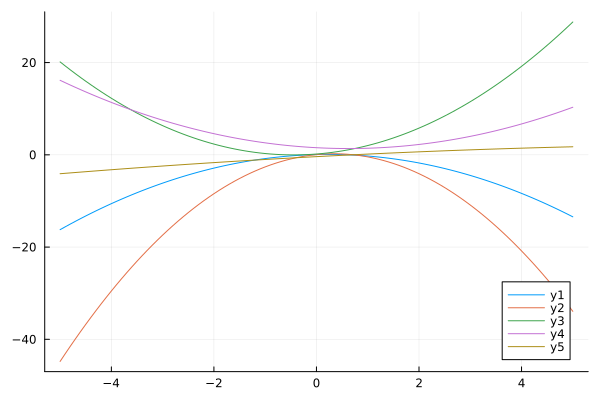

In [11]:
ys = mapslices(w->y(xs, w; ϕ=ϕₚ), ws, dims=1)
plot(xs, ys)

Very common BFM is a Gaussian kernel function: $$\phi_k(x|μs, σ²=1.0)= exp \left[ - \frac{||x-\mu||_2^2}{2\sigma^2} \right] $$

 
. We define it for 1D case as follows:

In [12]:
ϕₖ(x; μs, σ²=1.0) = [ exp(-(x-μ)^2/(2σ²)) for μ in μs]
@show ϕₖ(1;μs=rand(2));

ϕₖ(1; μs = rand(2)) = [0.9999945585576636, 0.9421636012739497]


μs = [-2.0, 0.0, 2.0]


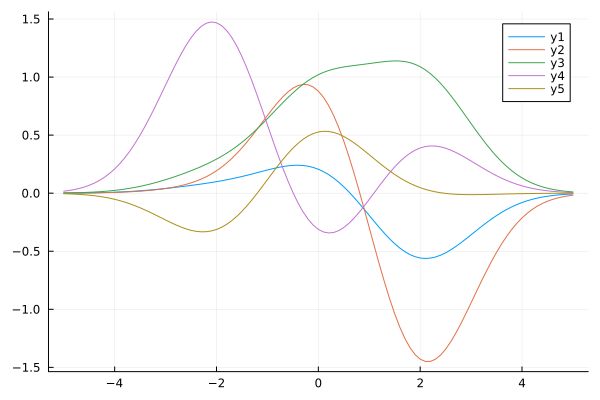

In [13]:
μs = [-2.0, 0.0, 2.0] # various Gaussian means
@show μs
ys = mapslices(w->y(xs, w; ϕ=x->ϕₖ(x;μs)), ws, dims=1)
plot(xs, ys)

Another option for basis functions, particularly for periodic data, is the Fourier basis. One straightforward approach is to choose a set of frequencies and phases and construct the basis as in: $$\phi_0(x)=1, \phi_j(x) = cos(w_jx + \psi_j)$$

In [14]:
ϕⱼ(x;wⱼ,ψⱼ) = [1; cos.(wⱼ*x+ψⱼ)]
@show ϕⱼ(5;wⱼ=rand(3),ψⱼ=rand(3));

ϕⱼ(5; wⱼ = rand(3), ψⱼ = rand(3)) = [1.0, -0.843589201052022, -0.4465115098637855, -0.45228660371933516]


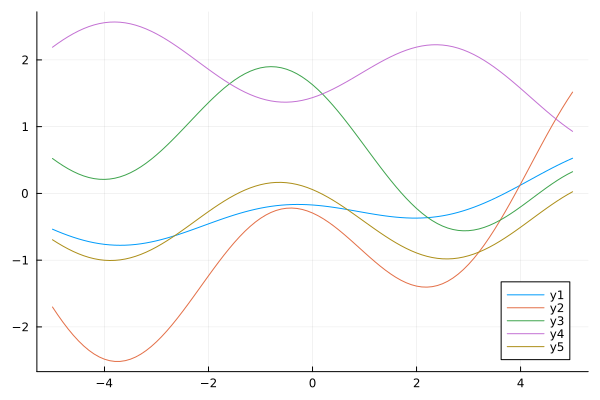

In [15]:
wⱼ=rand(2)
ψⱼ=rand(2)
ys = mapslices(w->y(xs, w; ϕ=x->ϕⱼ(x;wⱼ,ψⱼ)), ws, dims=1)
plot(xs, ys)

## Maximum Likelihood Estimation

$$
\begin{gather}
\text{The coefficients values, } w \text{ , are obtained by fitting } y(x,w) \text { to training data : } t \qquad \qquad \qquad \qquad \qquad \qquad
\\
\\
\text{ * We assume that : }
\begin{cases}
\text { - the target variable t is given by a deterministic function } y(x,w) 
\\
\text{ - with AGWN - Additive White Gaussian Noise - so that } \; t = y(x,w) + \epsilon
\\
\text{ - where } \epsilon \text { is a zero mean Gaussian R.V. with precision (inverse variance), } \beta^{-1} = \sigma^2
\end{cases}
\\
\\
\text { Thus, a model of the above linear model for regression is } 
\\
\\
p(t|x,w,\beta) = \mathcal{N}(t|y(x,w),\beta^{-1})
\\
\\
\text{ By {\color{Salmon}minimizing} an } \mathbf{ error \space function} \text{ , a measure of misfit between function } y(x,w) \qquad \qquad \qquad \qquad \qquad
\\
\text { for any given value of } w \text {, and the training set data points } t. \qquad \qquad
\\
\\
\text { * A choice of error function is : }
\begin{cases}
\text{ - the sum of the squares of the errors } \qquad \qquad \qquad \qquad \qquad \qquad \qquad
\\
\text{ - between predictions } y(x,w)
\\
\text{ - for each point } x_i \text { and }
\\
\text{ - corresponding target values } t_i
\\
\end{cases}
\\
\\
E(w) = \frac{1}{2} \sum_{i=1}^N (t_i - y(x_i,w))^2 
\\
\qquad \quad = \frac{1}{2} \sum_{i=1}^N (t_i - w^T \phi(x_i))^2
\end{gather}
$$

| |
|:-:|
| <img src="https://raw.githubusercontent.com/setrar/SSP/main/Homework/1/support/images/MLE-SGD_mle.png" width='' height='' /> |
| [Image Source](https://www.reliawiki.com/images/6/6c/Apa_fig3.png) |

$$
\begin{gather}
\text { The likelihood function of the conditional distribution } p(t|x,w,\beta) \; is \qquad \qquad \qquad
\\
\\
p(t|x,w,\beta) = \prod_{i=1}^N \mathcal{N}(t|w^T\phi(x_i),\beta^{-1})
\\
\text { And its logarithm is } \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad
\\
\\
\ln p(t|x,w,\beta) = \sum_{i=1}^N \ln \mathcal{N}(t|w^T\phi(x_i),\beta^{-1}) = \frac{N}{2} \ln \beta - \frac{N}{2} \ln (2 \pi) - E(w)
\\
\\
\text { In order to find parameters of a linear basis function model, }  p(t|x,w,\beta) ,
\\
\text { we maximize likelihood or minimizing }
\text { the negative log likelihood w.r.t } w:
\\
\\
\operatorname*{arg\,min}_{w,\beta} - \ln p(t|x,w,\beta)
\end{gather}
$$

# References
- [ ] [MLE Optimization for Regression Models](https://wildart.github.io/post/mle-sgd)